In [1]:
import os
import numpy as np

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [2]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [3]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 54s 106ms/step - loss: 0.3012 - val_loss: 0.2743
Epoch 2/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2741 - val_loss: 0.2686
Epoch 3/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2629 - val_loss: 0.2783
Epoch 4/20
500/500 [==============================] - 54s 107ms/step - loss: 0.2530 - val_loss: 0.2789
Epoch 5/20
500/500 [==============================] - 57s 113ms/step - loss: 0.2461 - val_loss: 0.2860
Epoch 6/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2378 - val_loss: 0.2852
Epoch 7/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2312 - val_loss: 0.2928
Epoch 8/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2242 - val_loss: 0.2999
Epoch 9/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2190 - val_loss: 0.2996
Epoch 10/20
500/500 [==============================] - 57s 114ms/step - l

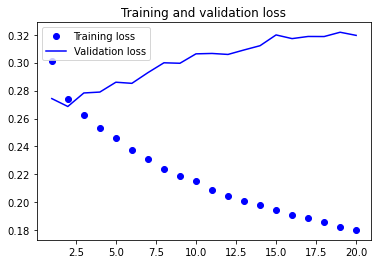

In [6]:
plot_loss(history)

In [7]:
model = Sequential()
model.add(layers.LSTM(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 89s 175ms/step - loss: 0.3154 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 83s 166ms/step - loss: 0.2931 - val_loss: 0.2741
Epoch 3/40
500/500 [==============================] - 82s 164ms/step - loss: 0.2854 - val_loss: 0.2714
Epoch 4/40
500/500 [==============================] - 82s 164ms/step - loss: 0.2795 - val_loss: 0.2740
Epoch 5/40
500/500 [==============================] - 82s 164ms/step - loss: 0.2753 - val_loss: 0.2729
Epoch 6/40
500/500 [==============================] - 81s 163ms/step - loss: 0.2696 - val_loss: 0.2743
Epoch 7/40
500/500 [==============================] - 81s 162ms/step - loss: 0.2649 - val_loss: 0.2727
Epoch 8/40
500/500 [==============================] - 82s 164ms/step - loss: 0.2617 - val_loss: 0.2713
Epoch 9/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2595 - val_loss: 0.2746
Epoch 10/40
500/500 [==============================] - 81s 163ms/step - l

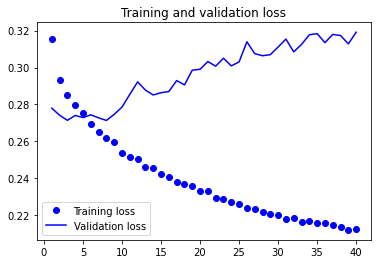

In [8]:
plot_loss(history)